# Estimating Business cost of fraud
Our LSTM model does well on statistitical tests showing strong precision and recall however in a buiness context the cost  of False negatives and False postiives is far from symetric. As such considering the total cost of miss classifying cases should be considered in the problem context.
estimating the cost of fraud for an individual is a simplier taks however from a bank's perspective both the individual and merchant matter. This notebook will go through the process of estimating the cost.

In [1]:
import pandas as pd
import numpy as np

# Combine both datasets to allow for my own train/test split
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

df = pd.concat([train_df,test_df], ignore_index=True)

# False negative cost

The cost of a false negative (or a fraudulent transaction not stopped) is more than just that transaction amount. in Card not present environments (one where a customer makes a purchase without physically presenting their credit or debit card to the business) the cardholders are typically reimbursed. There are also costs involved with investigating reports, chargebacks and reputational damages. As such the exact cost is difficut to determin however srouces such as LexisNexis Risk solutions estimate the cost to the buiness to be around 3.68 per dollar lost. Based on these findings the cost of a false postive will be the fraudlent amount multiplied by a secondary cost multiplier (representing the external costs involved by merchants). THis multiplier will be around [2-4] (a range around what exisNexis Risk solutions estimates)


- Cost_FN = mean_fraud_amount * Seconday cost

In [2]:
mean_fraud_amount = df.loc[df['is_fraud'] == 1, 'amt'].mean()
print(mean_fraud_amount)

530.661412288882


In [3]:
Secondary_cost =  np.linspace(2.0, 4.0, 5)

# False postive cost
Estimating the cost of a false postive can be much more difficult expecially when condidering a merchants perepective. research shows that false positives can actually cost merchants more (in total) than fraud and as such we need to balance this with false negatives. When a transaction is declined a merchant looses the sale plus many more intangable costs. For instance the mmediate revenue of the sale is lost, the customer may call support resulting in labour costs, there is a chance of reputatoinal damage and damage of customer relationship. Reaserch from riskified estimtates that around 40% of customers will churn from a business if their card is block from a purchase. As all these intangable costs are difficult to measure and are dependent on may factors (and due to limited data) accuratly estimtaing the cost of false is difficult. That being said for the purposes of this investigation we will take the cost of the false positive as the following:
- Cost_FP = median_sales_amt + service_cost + CLV * retention rate

median_sales_amt represents the revenue lost for the merchant (taking the median as the data is highly skewed), service cost accounting for the cost of handeling customer support and such and CLV * retention rate will estimate the lost revenue from churning customers

In [4]:
median_sales_amt = df['amt'].median()
print(median_sales_amt)

47.45


In [5]:
Service_cost = np.arange(5, 11, 1)    

### Estimating CLV

estimating CLV is difficult as I have no data on churn rates. As such I will just assume yearly spending per merchant is constetn and will only account for 1 year (i.e. only account for next years sales and nothing byond that). To estimte CLV I will get the average spending of an individual across the year for an individual merchant

In [6]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['year'] = df['trans_date_trans_time'].dt.year

In [8]:
df_2023 = df[df['year'] == 2020]

avg_spend_per_merchant = (
    df_2023.groupby(['cc_num', 'merchant'])['amt']
    .mean()
    .reset_index(name='avg_yearly_spend')
)

In [9]:
overall_avg_spend = avg_spend_per_merchant['avg_yearly_spend'].mean()
print(overall_avg_spend)


70.47082826452385


Reaserch from riskified estimtates that around 40% of customers will churn from a business if their card is block from a purchase. The accuracy of this is difficult to determine as its based on many factors. As I lack the data to test this I will do sensitivity analysis ranging from 30-45%

In [10]:
retention_rate = np.array([0.30, 0.35, 0.40, 0.45])

# LSTM

In [11]:
from tensorflow import keras
import pandas as pd

model = keras.models.load_model("lstm_fraud_model.keras")
print("✅ Model loaded.")

✅ Model loaded.


In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer

In [13]:
LSTM_df = pd.read_csv('modeling_df.csv')


In [14]:
# Data preperation:
num_feats = ['amt', 'trans_hour', 'time_since_last', 'last_amt']
cat_feats = ['category']
features = num_feats + cat_feats

LSTM_num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', add_indicator=True))
])

LSTM_cat_pipe = Pipeline([
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

Preporcessor = ColumnTransformer([
    ('num', LSTM_num_pipe, num_feats),
    ('cat', LSTM_cat_pipe, cat_feats)
])

LSTM_df.sort_values(['cc_num','trans_date_trans_time'], inplace=True)
LSTM_df.reset_index(drop=True, inplace=True)

# Getting train/ test splits
n = len(LSTM_df)
x = int(0.7 * n)    # 70% mark
i = int(0.85 * n)   # 85% mark

train_LSTM = LSTM_df.iloc[:x]
val_LSTM = LSTM_df.iloc[x:i]
test_LSTM = LSTM_df.iloc[i:]

y_train_LSTM = train_LSTM['is_fraud'].to_numpy().astype(int)
y_val_LSTM   = val_LSTM['is_fraud'].to_numpy().astype(int)
y_test_LSTM  = test_LSTM['is_fraud'].to_numpy().astype(int)

id_train = train_LSTM['cc_num'].to_numpy()
id_val   = val_LSTM['cc_num'].to_numpy()
id_test  = test_LSTM['cc_num'].to_numpy()

t_train = train_LSTM['trans_date_trans_time']
t_val   = val_LSTM['trans_date_trans_time']
t_test  = test_LSTM['trans_date_trans_time']

# Transform Data using pipelines
LSTM_train = Preporcessor.fit_transform(train_LSTM[features])
LSTM_val = Preporcessor.transform(val_LSTM[features])
LSTM_test = Preporcessor.transform(test_LSTM[features])

In [15]:
def build_windows_by_group(X_rows, y_rows, group_ids, times, lookback=64, stride=1):
    """
    Returns:
      X_seq: (Nw, T, F)
      y_seq: (Nw,)
    """

    #idx gets the original index
    idx = np.arange(len(y_rows))
    order_df = pd.DataFrame({'i': idx, 'id': group_ids, 't': pd.to_datetime(times)})
    order_df.sort_values(['id','t'], kind='mergesort', inplace=True)

    Xs, ys = [], []

    # for each id we create a block i.e. a list of global indicies for all the same transactions 
    for g, block in order_df.groupby('id', sort=False):
        I = block['i'].to_numpy()
        n = len(I)
        if n < lookback:
            continue
        # slide the window across the block by 'stride' and appending the features and y lable to Xs and ys
        for stop in range(lookback, n+1, stride):
            win_idx = I[stop-lookback:stop]
            Xs.append(X_rows[win_idx])
            ys.append(y_rows[win_idx[-1]])  # label = last row in window
    return np.asarray(Xs), np.asarray(ys).astype(int)

Lookback = 32
# How far each window slides
Stride = 2


# Build training window
X_tr_seq, y_tr_seq = build_windows_by_group(LSTM_train, y_train_LSTM, id_train, t_train,
                                            lookback=Lookback, stride=Stride)
X_va_seq, y_va_seq = build_windows_by_group(LSTM_val,   y_val_LSTM,   id_val,   t_val,
                                            lookback=Lookback, stride=Stride)
X_te_seq, y_te_seq = build_windows_by_group(LSTM_test,  y_test_LSTM,  id_test,  t_test,
                                            lookback=Lookback, stride=Stride)

def make_ds(X, y, batch_size=256, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(y), 8192), seed=123)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
BATCH = 256
ds_tr = make_ds(X_tr_seq, y_tr_seq, batch_size=BATCH, shuffle=True)
ds_va = make_ds(X_va_seq, y_va_seq, batch_size=BATCH, shuffle=False)
ds_te = make_ds(X_te_seq, y_te_seq, batch_size=BATCH, shuffle=False)

# Cost Analysis

In previous note books we set the probability threshold to maximise the F1 score, however to optimise our model for real world cost we will set the threshold to minimise the cost (based on reaserch)

In [16]:
# Collects the label and probability score for each data point
def collect_labels_probs(ds, model):
    y = np.concatenate([y.numpy() for _, y in ds]).ravel()
    p = model.predict(ds, verbose=0).ravel()  # model outputs P(fraud)
    return y, p

# Get validation / test labels & probs (adjust ds_va, ds_te, model to your names)
y_val, p_val = collect_labels_probs(ds_va, model)
y_test, p_test = collect_labels_probs(ds_te, model)


Expected Cost(t)=FP(t)×CFP​+FN(t)×CFN​

In [17]:
# Calculte cost based on C_FP and C_FN values
def expected_cost(y_true, p, t, cost_fp, cost_fn):
    y_pred = (p >= t).astype(int)
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return fp * cost_fp + fn * cost_fn, fp, fn

In [18]:
# Selects the threshold that minimises cost
def pick_t_star_on_val(y_val, p_val, c_fp, c_fn, grid=np.linspace(0.001, 0.999, 400)):
    costs = []
    for t in grid:
        c, _, _ = expected_cost(y_val, p_val, t, c_fp, c_fn)
        costs.append(c)
    j = int(np.argmin(costs))
    return float(grid[j]), float(costs[j])


In [19]:
records = []
thr_grid = np.linspace(0.001, 0.999, 400)

for sec in Secondary_cost:
    c_fn = mean_fraud_amount * sec
    for svc in Service_cost:
        for r in retention_rate:
            c_fp = median_sales_amt + svc + (overall_avg_spend * r)
            # choose threshold on validation
            t_star, val_cost_min = pick_t_star_on_val(y_val, p_val, c_fp, c_fn, grid=thr_grid)
            # evaluate that threshold on test
            test_cost, fp, fn = expected_cost(y_test, p_test, t_star, c_fp, c_fn)
            records.append({
                "secondary_cost": sec,
                "service_cost": svc,
                "retention_rate": r,
                "C_FN": c_fn, "C_FP": c_fp,
                "t_star": t_star,
                "val_min_cost": val_cost_min,
                "test_total_cost": test_cost,
                "test_avg_cost": test_cost / len(y_test),
                "test_FP": fp, "test_FN": fn
            })

sens = pd.DataFrame(records)
sens.head(10)

,secondary_cost,service_cost,retention_rate,C_FN,C_FP,t_star,val_min_cost,test_total_cost,test_avg_cost,test_FP,test_FN
0,2.0,5,0.30,1061.322825,73.591248,0.011005,22868.465072,23898.742550,0.174779,94,16
1,2.0,5,0.35,1061.322825,77.114790,0.011005,23150.348385,24229.955443,0.177201,94,16
2,2.0,5,0.40,1061.322825,80.638331,0.011005,23432.231698,24561.168336,0.179623,94,16
3,2.0,5,0.45,1061.322825,84.161873,0.011005,23714.115011,24892.381229,0.182046,94,16
4,2.0,6,0.30,1061.322825,74.591248,0.011005,22948.465072,23992.742550,0.175466,94,16
5,2.0,6,0.35,1061.322825,78.114790,0.011005,23230.348385,24323.955443,0.177889,94,16
6,2.0,6,0.40,1061.322825,81.638331,0.011005,23512.231698,24655.168336,0.180311,94,16
7,2.0,6,0.45,1061.322825,85.161873,0.011005,23794.115011,24986.381229,0.182733,94,16
8,2.0,7,0.30,1061.322825,75.591248,0.011005,23028.465072,24086.742550,0.176154,94,16
9,2.0,7,0.35,1061.322825,79.114790,0.011005,23310.348385,24417.955443,0.178576,94,16


# Visualisations

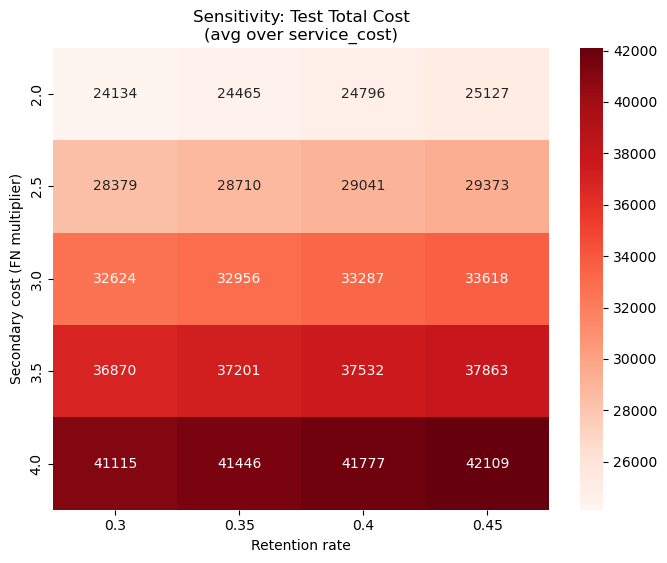

In [20]:
import seaborn as sns

pivot_cost = sens.pivot_table(values='test_total_cost',
                              index='secondary_cost',
                              columns='retention_rate',
                              aggfunc='mean')  # average over service_cost

plt.figure(figsize=(8,6))
sns.heatmap(pivot_cost, cmap='Reds', annot=True, fmt=".0f")
plt.title("Sensitivity: Test Total Cost\n(avg over service_cost)")
plt.xlabel("Retention rate")
plt.ylabel("Secondary cost (FN multiplier)")
plt.show()


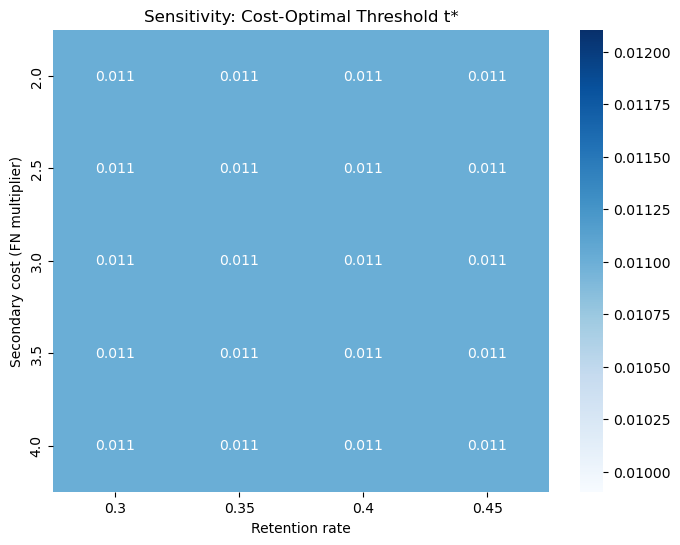

In [21]:
pivot_t = sens.pivot_table(values='t_star',
                           index='secondary_cost',
                           columns='retention_rate',
                           aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(pivot_t, cmap='Blues', annot=True, fmt=".3f")
plt.title("Sensitivity: Cost-Optimal Threshold t*")
plt.xlabel("Retention rate")
plt.ylabel("Secondary cost (FN multiplier)")
plt.show()


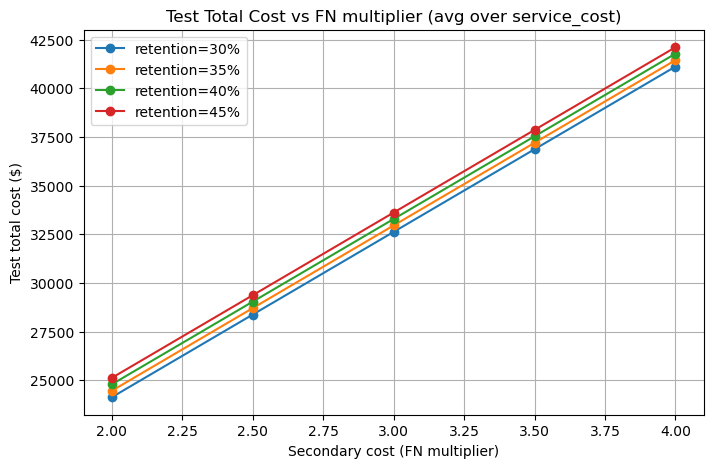

In [22]:
plt.figure(figsize=(8,5))
for r in retention_rate:
    subset = sens[sens['retention_rate']==r]
    line = subset.groupby('secondary_cost')['test_total_cost'].mean()
    plt.plot(line.index, line.values, marker='o', label=f"retention={int(r*100)}%")
plt.title("Test Total Cost vs FN multiplier (avg over service_cost)")
plt.xlabel("Secondary cost (FN multiplier)")
plt.ylabel("Test total cost ($)")
plt.grid(True); plt.legend()
plt.show()


In [27]:
y_pred_test = (p_test >= t_star).astype(int)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

avg_cost_per_txn = test_cost / len(y_test)

print("\n[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):")
print(cm)
print(f"Avg cost/txn = {avg_cost_per_txn:.4f}")
print("Classification report (Test):\n", classification_report(y_test, y_pred_test, digits=4))


[Test @ t*] Confusion matrix (rows actual 0/1, cols pred 0/1):
[[136002     94]
 [    16    625]]
Avg cost/txn = 0.3097
Classification report (Test):
               precision    recall  f1-score   support

           0     0.9999    0.9993    0.9996    136096
           1     0.8693    0.9750    0.9191       641

    accuracy                         0.9992    136737
   macro avg     0.9346    0.9872    0.9594    136737
weighted avg     0.9993    0.9992    0.9992    136737



# Model deployment
Next we will delpoy our finalised LSTM model using the fast API but first we will need to save some artifacts

### Saving atrifacts

We will save the following atrifacts:
- Preprocessor
- Feature schema
- Window configs
- Probability threshold
- Model card
- Code environemnt

In [24]:
import json, joblib, datetime, platform, sys, os
import numpy as np
from tensorflow import keras
from datetime import datetime, UTC

In [25]:
ART_DIR = "artifacts_fraud_detec"

# Save model
model.save(f"{ART_DIR}/lstm_fraud_model.keras")

# Save preprocessor (fitted ColumnTransformer)
joblib.dump(Preporcessor, f"{ART_DIR}/preprocessor.joblib")

# Feature config i.e. what data the model expects
raw_schema = {
    "features_in_order": ["amt","trans_hour","time_since_last","last_amt","category"],
    "dtypes": {
        "amt": "float64",
        "trans_hour": "int64",
        "time_since_last": "float64",
        "last_amt": "float64",
        "category": "string"
    }
}
with open(f"{ART_DIR}/schema.json", "w") as f:
    json.dump(raw_schema, f, indent=2)
feat_names = Preporcessor.get_feature_names_out().tolist()

windowing = {
    "id_col": "cc_num",                       # your ID column
    "time_col": "trans_date_trans_time",      # your timestamp column
    "timesteps": 32,                          # window length (lookback)
    "stride": 2,                              # window stride
    "n_features": len(feat_names),            # number of encoded features
    "features_in_order": ["amt", "trans_hour", "time_since_last", "last_amt", "category"]
}

with open(f"{ART_DIR}/windowing.json", "w") as f:
    json.dump(windowing, f, indent=2)
    
t_star = float(t_star)  # Optimal Threshold Based on cost analysis - 0.2792 threshold optimises f1
with open(f"{ART_DIR}/threshold.json", "w") as f:
    json.dump({"t_star": t_star, "selected_on": "validation", "method": "cost_min"}, f, indent=2)


# Model Summary
now = datetime.now(UTC).isoformat().replace("+00:00", "Z")
model_card = {
    "version": "v1",
    "created_at_utc": now,
    "framework": f"tensorflow/{keras.__version__}",
    "python": sys.version,
    "os": platform.platform(),
    "algorithm": "LSTM (binary)",
    "windowing": windowing,
    "features_raw": raw_schema["features_in_order"],
    "operating_point": {"threshold": t_star, "based_on": "min_expected_cost"},
    "notes": "Trained with EarlyStopping on val_AUC; cost-tuned threshold on validation; evaluated on hold-out test."
}
with open(f"{ART_DIR}/model_card.json", "w") as f:
    json.dump(model_card, f, indent=2)

# Package requirements
reqs = """fastapi
uvicorn
pydantic
numpy
pandas
scikit-learn
tensorflow
joblib
"""
with open(f"{ART_DIR}/requirements.txt", "w") as f:
    f.write(reqs)